### Setup
Read all images.

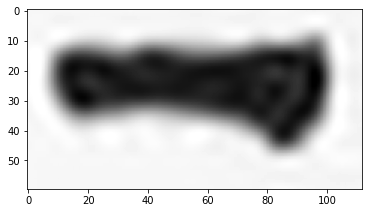

In [293]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
from os import walk

gray_factor = (0.2989, 0.5870, 0.1140)

def to_gray_scale(rgb):
    return np.dot(rgb[..., :3], gray_factor)

dirpath, _, filenames = next(walk('./../data/bounds/'))
images = [to_gray_scale(img.imread(dirpath + name)) for name in filenames]
plt.imshow(images[0], cmap='gray')

### Check region method
Now we should understand which method for checking region (is it completely white)
it is better to use. As we can see numpy is highly preferred to use because we win
a lot of time.

In [275]:
def check_reg(d, x1, y1, x2, y2):
    for x in range(x1, x2):
        for y in range(y1, y2):
            if not d[x, y]: return False
    return True

def check_reg_numpy(d, x1, y1, x2, y2):
    np.all(d[x1:x2, y1:y2])

%timeit check_reg(images[0], 1, 10, 56, 106)
%timeit check_reg_numpy(images[0], 1, 10, 56, 106)

319 µs ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.42 µs ± 790 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Simple solution
This solution just makes wider bounds until it reaches the black point.

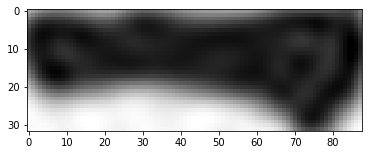

In [311]:
THRESHOLD = 0.4

def bounds_simple(d):
    h, w = d.shape
    matrix = d > THRESHOLD

    top = 0
    while np.all(matrix[top-1:top, :]) and top < h:
        top += 1

    bottom = h
    while np.all(matrix[bottom:bottom+1, :]) and bottom > 0:
        bottom -= 1

    left = 0
    while np.all(matrix[:, left-1:left]) and left < w:
        left += 1

    right = w
    while np.all(matrix[:, right:right+1]) and right > 0:
        right -= 1

    return top, bottom, left, right

top, bottom, left, right = bounds_simple(images[0])
plt.imshow(images[0][top:bottom, left:right], cmap='gray')
plt.show()

### Problem with simple solution
As we can see red regions are checking twice.

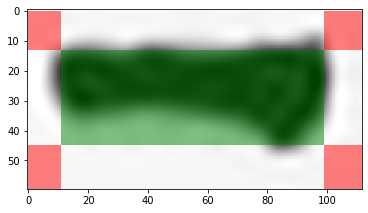

In [312]:
from matplotlib.patches import Rectangle

h, w = images[0].shape
fig,ax = plt.subplots(1)
ax.imshow(images[0], cmap='gray')
ax.add_patch(Rectangle((0, 0), left, top, facecolor='r', alpha=0.5))
ax.add_patch(Rectangle((right, 0), w - right, top, facecolor='r', alpha=0.5))
ax.add_patch(Rectangle((0, bottom), left, h - bottom, facecolor='r', alpha=0.5))
ax.add_patch(Rectangle((right, bottom), w - right, h - bottom, facecolor='r', alpha=0.5))
ax.add_patch(Rectangle((left, top), right - left, bottom - top, facecolor='g', alpha=0.5))
plt.show()


### Simple solution + cut
Not let us check red regions only one time. Speed **-10%**. But that is not
enough.

In [278]:
def bounds_simple_cut(d):
    h, w = d.shape
    matrix = d > THRESHOLD

    top = 0
    while np.all(matrix[top-1:top, :]) and top < h:
        top += 1

    bottom = h
    while np.all(matrix[bottom:bottom+1, :]) and bottom > 0:
        bottom -= 1

    left = 0
    while np.all(matrix[top:bottom+1, left-1:left]) and left < w:
        left += 1

    right = w
    while np.all(matrix[top:bottom+1, right:right+1]) and right > 0:
        right -= 1

    return top, bottom, left, right

%timeit [bounds_simple(image) for image in images]
%timeit [bounds_simple_cut(image) for image in images]

3.53 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.17 ms ± 95.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Binary search
If we suppose that our image has a continuous range of black points we can consider
it as a monotonically increasing function. In this case, we can save significant time
using binary search.

In [318]:
def binary_search(l, r, check):
    while l != r:
        md = (l + r) // 2
        if check(md):
            l = md + 1
        else:
            r = md
    return l

def bounds_binary_search(d):
    h, w = d.shape
    matrix = d > THRESHOLD

    center_x, center_y = h // 2, w // 2

    top = binary_search(0, center_x, lambda x: np.all(matrix[x-1:x, :]))
    bottom = binary_search(center_x, h, lambda x: not np.all(matrix[x:x+1, :])) - 1
    left = binary_search(0, center_y, lambda x: np.all(matrix[top:bottom+1, x-1:x]))
    right = binary_search(center_y, w, lambda x: not np.all(matrix[top:bottom+1, x:x+1])) - 1
    return top, bottom, left, right

### Check result
Now we should check the binary search solution and measure time. As we can see
**-64%**. Good result!

In [337]:
def check_function(images, f):
    for ix, image in enumerate(images):
        binary = f(image)
        simple = bounds_simple(image)
        if binary != simple:
            raise Exception(f"# {ix}: Wrong answer: binary {binary}, simple: {simple}")

check_function(images, bounds_binary_search)
%timeit [bounds_simple(image) for image in images]
%timeit [bounds_simple_cut(image) for image in images]
%timeit [bounds_binary_search(image) for image in images]

3.71 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.61 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.32 ms ± 8.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### But... still we have one issue
What if the black region is not in the center of an image? For example:

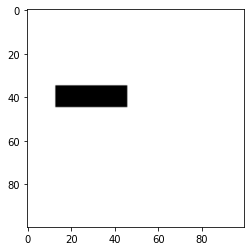

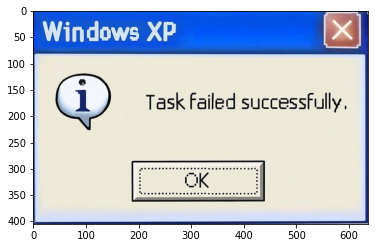

In [334]:
hack_image = np.ones((100, 100))
hack_image[35:45, 13:46] = 0
advanced_images = images + [hack_image]

plt.imshow(hack_image, cmap='gray')
plt.show()

try:
    check_function([hack_image], bounds_binary_search)
except:
    plt.imshow(img.imread('./../data/secret.png'))

### Let's fix it
Now we should efficiently find the black region. In order to deal with it, we must
use BFS and divide image every time into four regions, and recursively check them.
Red dots show the place where we had a check.

(37, 37)

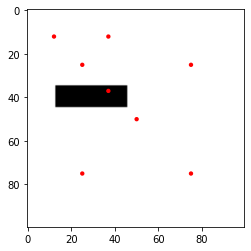

In [335]:
from collections import deque
from matplotlib.patches import Circle

_,ax = plt.subplots(1)
ax.imshow(hack_image, cmap='gray')

def search_center(matrix):
    h, w = matrix.shape
    q = deque()
    q.append((0, 0, h, w))
    while len(q) > 0:
        x1, y1, x2, y2 = q.popleft()
        if x1 == x2 - 1 or y1 == y2 - 1: continue

        md_x = (x1 + x2) // 2
        md_y = (y1 + y2) // 2
        ax.add_patch(Circle((md_x, md_y), radius=1, facecolor='r'))
        if not matrix[md_x, md_y]: return md_x, md_y

        q.extend([
            (x1, y1, md_x, md_y),
            (md_x, y1, x2, md_y),
            (md_x, md_y, x2, y2),
            (x1, md_y, md_x, y2),
        ])
    raise Exception("Can not find region")

search_center(hack_image)

### Done
Finally, we can pack it all together!

In [336]:
def bounds_binary_search_with_center(d):
    h, w = d.shape
    matrix = d > THRESHOLD

    center_x, center_y = search_center(matrix)

    top = binary_search(0, center_x, lambda x: np.all(matrix[x-1:x, :]))
    bottom = binary_search(center_x, h, lambda x: not np.all(matrix[x:x+1, :])) - 1
    left = binary_search(0, center_y, lambda x: np.all(matrix[top:bottom+1, x-1:x]))
    right = binary_search(center_y, w, lambda x: not np.all(matrix[top:bottom+1, x:x+1])) - 1
    return top, bottom, left, right

check_function([hack_image], bounds_binary_search_with_center)

(60, 112)